# Searching multiple ERDDAP servers

The latest erddapy module release (v1.2.0) added a multiple servers search similar to the web one implemented in
[https://coastwatch.pfeg.noaa.gov/erddap/download/SearchMultipleERDDAPs.html](https://coastwatch.pfeg.noaa.gov/erddap/download/SearchMultipleERDDAPs.html).
The Python interface allow the user to mix powerful variable handling and visualization with the query results.

Let us explore an example
[based on this](https://nbviewer.jupyter.org/gist/rsignell-usgs/f2be18f9db07a3c2970d88576cd62b57)
Rich Signell's gist where we search for salinity time-series data in a specific region and time span.

In [1]:
min_time = "2017-07-01T00:00:00Z"
max_time = "2017-09-01T00:00:00Z"
min_lon, max_lon = -127, -123.75
min_lat, max_lat = 43, 48
standard_name = "sea_water_practical_salinity"


kw = {
    "standard_name": standard_name,
    "min_lon": min_lon,
    "max_lon": max_lon,
    "min_lat": min_lat,
    "max_lat": max_lat,
    "min_time": min_time,
    "max_time": max_time,
    "cdm_data_type": "timeseries",
}


servers = {
    "ooi": "https://erddap.dataexplorer.oceanobservatories.org/erddap/",
    "ioos": "https://erddap.sensors.ioos.us/erddap/",
}

We will restrict the search to two servers, IOOS sensors and OOI Data Explorer. If one leaves the `server_list` empty the search will iterate all servers listed in the
[Awesome ERDDAP list](https://github.com/IrishMarineInstitute/awesome-erddap).

In [2]:
from erddapy.multiple_server_search import advanced_search_servers


df = advanced_search_servers(servers_list=servers.values(), **kw)

df.head()

,Title,Institution,Dataset ID,Server url
0,Coastal Endurance: Oregon Inshore Surface Moor...,Ocean Observatories Initiative (OOI),ooi-ce01issm-rid16-02-flortd000,https://erddap.dataexplorer.oceanobservatories...
1,Coastal Endurance: Oregon Inshore Surface Moor...,Ocean Observatories Initiative (OOI),ooi-ce01issm-rid16-03-ctdbpc000,https://erddap.dataexplorer.oceanobservatories...
2,Coastal Endurance: Oregon Inshore Surface Moor...,Ocean Observatories Initiative (OOI),ooi-ce01issm-rid16-03-dostad000,https://erddap.dataexplorer.oceanobservatories...
3,Coastal Endurance: Oregon Inshore Surface Moor...,Ocean Observatories Initiative (OOI),ooi-ce01issm-rid16-07-nutnrb000,https://erddap.dataexplorer.oceanobservatories...
4,Coastal Endurance: Oregon Inshore Surface Moor...,Ocean Observatories Initiative (OOI),ooi-ce01issm-rid16-06-phsend000,https://erddap.dataexplorer.oceanobservatories...


Now that we have a list of dataset_ids we can iterate and get their positions to create a map.
The functions below will create a download URL for the longitude and latitude and request the data as a pandas dataframe.

In [3]:
import pandas as pd
from erddapy import ERDDAP


kw = {
    "longitude>=": min_lon,
    "longitude<=": max_lon,
    "latitude>=": min_lat,
    "latitude<=": max_lat,
    "time>=": min_time,
    "time<=": max_time,
}


def download_url(server, dataset_id):
    e = ERDDAP(server, protocol="tabledap")
    url = e.get_download_url(
        dataset_id=dataset_id,
        response="csvp",
        variables=["longitude", "latitude"],
        constraints=kw,
        distinct=True,
    )
    return url

def request_positions(download_url):
    df = pd.read_csv(download_url)
    return df.values.squeeze().tolist()

Now we can iterate all the dataset ids we found. That is a slow operation depending on the number of datasets and it is good practice to save/cache the results to re-use them later. That will not only save us some time but it is also appreciated by the data providers maintaining the servers.

In [4]:
from pathlib import Path
import pickle

from tqdm.notebook import tqdm
from urllib.error import HTTPError
import numpy as np

path = Path("positions.p")

if not path.exists():
    positions = []
    for idx, row in tqdm(df.iterrows()):
        try:
            url = download_url(row["Server url"], row["Dataset ID"])
            pos = request_positions(url)
        except HTTPError as e:
            print(f"Failed downloading {url}")
            pos = [np.NaN, np.NaN]
        positions.append(pos)
    with open(path, "wb") as f:
        pickle.dump(positions, f)
else:
    with open(path, "rb") as f:
        positions = pickle.load(f)

0it [00:00, ?it/s]

Failed downloading https://erddap.dataexplorer.oceanobservatories.org/erddap/tabledap/ooi-ce01issm-rid16-03-ctdbpc000.csvp?longitude,latitude&longitude>=-127&longitude<=-123.75&latitude>=43&latitude<=48&time>=1498867200.0&time<=1504224000.0&distinct()
Failed downloading https://erddap.dataexplorer.oceanobservatories.org/erddap/tabledap/ooi-ce01issm-rid16-03-dostad000.csvp?longitude,latitude&longitude>=-127&longitude<=-123.75&latitude>=43&latitude<=48&time>=1498867200.0&time<=1504224000.0&distinct()
Failed downloading https://erddap.dataexplorer.oceanobservatories.org/erddap/tabledap/ooi-ce04ospd-dp01b-04-flntua103.csvp?longitude,latitude&longitude>=-127&longitude<=-123.75&latitude>=43&latitude<=48&time>=1498867200.0&time<=1504224000.0&distinct()
Failed downloading https://erddap.dataexplorer.oceanobservatories.org/erddap/tabledap/ooi-ce02shsm-rid27-02-flortd000.csvp?longitude,latitude&longitude>=-127&longitude<=-123.75&latitude>=43&latitude<=48&time>=1498867200.0&time<=1504224000.0&dis

In [5]:
df.loc[:, "lon"] = np.array(positions)[:, 0]
df.loc[:, "lat"] = np.array(positions)[:, 1]

df.dropna(inplace=True)

df_ioos = df.loc[df["Server url"] == servers["ioos"]]
df_ooi = df.loc[df["Server url"] == servers["ooi"]]

In [6]:
from ipyleaflet import AwesomeIcon, Marker, Map, LegendControl, FullScreenControl, Popup, Polyline, Rectangle
from ipywidgets import HTML


colors = {
    "IOOS": "blue",
    "OOI": "orange",
}


legend = LegendControl(
    colors,
    name="Dataset locations",
    position="bottomright",
)

def make_popup(row):
    classes = "table table-striped table-hover table-condensed table-responsive"
    return pd.DataFrame(row[["Institution", "Dataset ID"]]).to_html(
        classes=classes
    )

In [7]:
m = Map(center=((min_lat+max_lat) / 2, (min_lon+max_lon) / 2), zoom=6)
m.add_control(FullScreenControl())
m.add_control(legend)

rectangle = Rectangle(
    bounds=((min_lat, min_lon), (max_lat, max_lon)),
    color="red",
    fill=False,
)
m.add_layer(rectangle)

In [8]:
# IOOS
for k, row in df_ioos.iterrows():
    marker = Marker(
        icon=AwesomeIcon(name="life-ring", marker_color=colors["IOOS"]),
        location=(row["lat"], row["lon"]),
    )
    msg = HTML()
    msg.value = make_popup(row)
    marker.popup = msg
    m.add_layer(marker)

In [9]:
# OOI
for k, row in df_ooi.iterrows():
    marker = Marker(
        icon=AwesomeIcon(name="life-ring", marker_color=colors["OOI"]),
        location=(row["lat"], row["lon"]),
    )
    msg = HTML()
    msg.value = make_popup(row)
    marker.popup = msg
    m.add_layer(marker)

In [10]:
m

Map(center=[45.5, -125.375], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom…

User may also look for data that are located near to each other for sensor comparison or calibration.
The nested loop below is a simple way to find the stations that are nearest to each other starting from a 1 km distance.

In [11]:
import seawater as sw


dist = 1e3
for k_i, (lon_i, lat_i) in df_ioos[["lon", "lat"]].iterrows():
    for k_o, (lon_o, lat_o) in df_ooi[["lon", "lat"]].iterrows():
        lats = lat_i, lat_o
        lons = lon_i, lon_o
        new_dist, angle = sw.dist(lats, lons)
        if new_dist < dist:
            dist = new_dist
            ki, ko = k_i, k_o

In [12]:
print(f"The stations closest ({dist.squeeze():.2f} km) to each other are:")

The stations closest (0.65 km) to each other are:


In [13]:
df.loc[ki]

Title                                46098 - Moored Buoy
Institution    Observing System Monitoring Center (OSMC)
Dataset ID                                    osmc_46098
Server url        https://erddap.sensors.ioos.us/erddap/
lon                                              -124.95
lat                                            44.383335
Name: 65, dtype: object

In [14]:
df.loc[ko]

Title          Coastal Endurance: Oregon Offshore Surface Moo...
Institution                 Ocean Observatories Initiative (OOI)
Dataset ID                       ooi-ce04ossm-rid27-02-flortd000
Server url     https://erddap.dataexplorer.oceanobservatories...
lon                                                   -124.94508
lat                                                     44.37868
Name: 15, dtype: object

In [15]:
def download_salinity(server, dataset_id):
    print(f"Downloading {dataset_id=}.")
    e = ERDDAP(server, protocol="tabledap")
    e.dataset_id = dataset_id
    e.constraints = {"time>=": min_time,"time<=": max_time}
    e.response = "csv"
    e.variables = [
        "time",
        e.get_var_by_attr(dataset_id=dataset_id, standard_name=standard_name)[0]
    ]

    col = "time (UTC)"
    return e.to_pandas(parse_dates=[col], index_col=col)

In [16]:
dataset_id = df.loc[ki]["Dataset ID"]

sal_ioos = download_salinity(servers["ioos"], dataset_id)

In [17]:
dataset_id = df.loc[ko]["Dataset ID"]

sal_ooi = download_salinity(servers["ooi"], dataset_id)

<IPython.core.display.Javascript object>


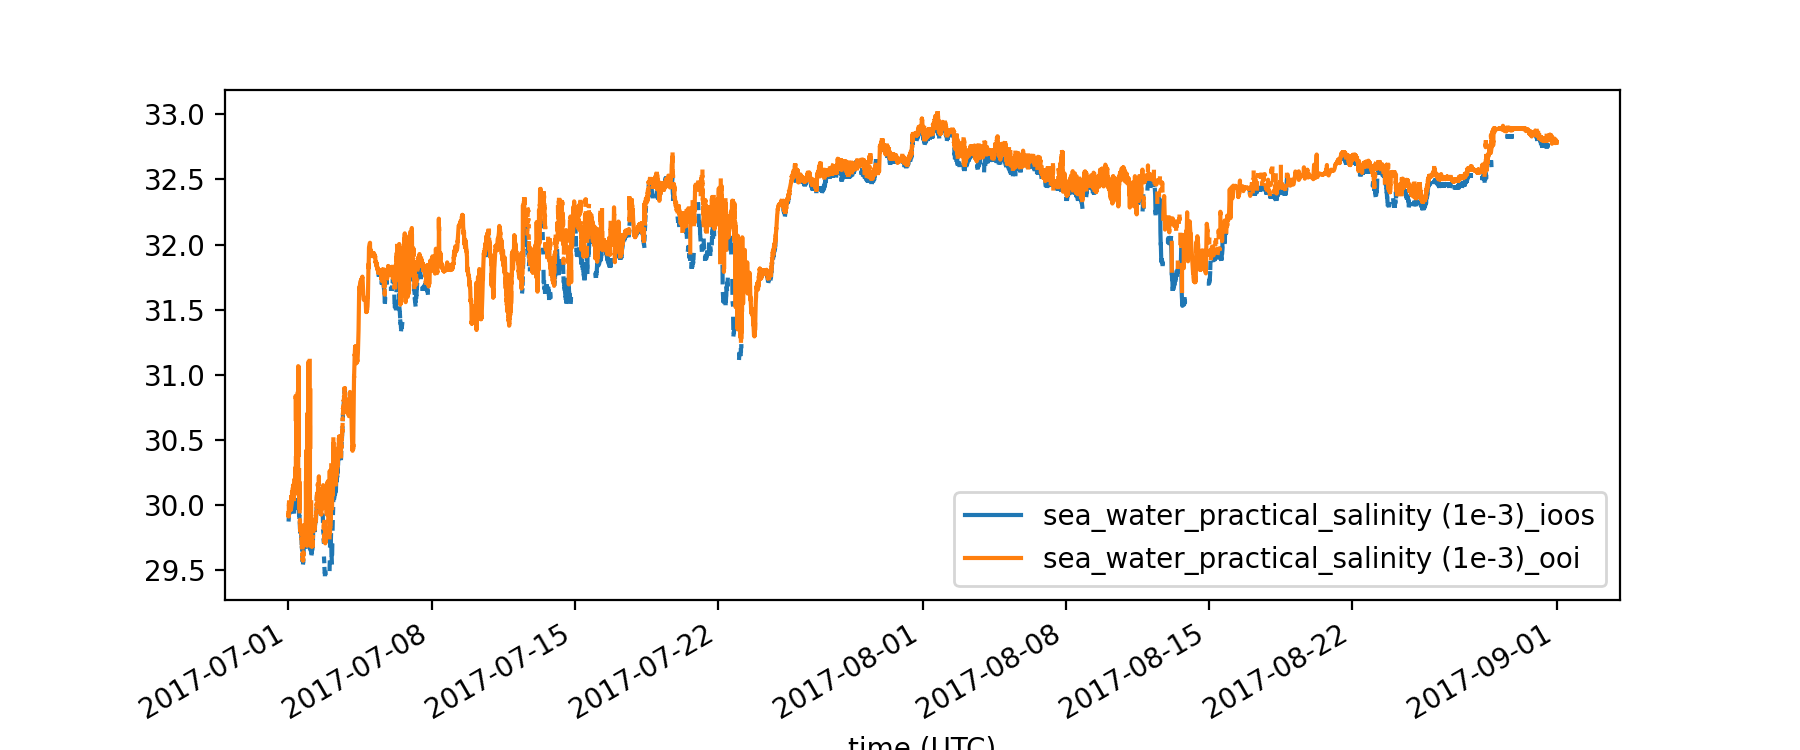

In [18]:
%matplotlib notebook
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()


fig, ax = plt.subplots(figsize=(9, 3.75))
pd.merge(sal_ioos,sal_ooi,on='time (UTC)',suffixes=('_ioos','_ooi'), how='outer').plot(ax=ax)
fig.autofmt_xdate();

Hopefully this new feature is useful and be sure to also check the simple search functionality (`search_servers`) in case one wants to browse data without extra constraints.